# Creating the Bathymetry

Name: Stanley Nguyen

Date: 10/28/24

In this notebook, I describe the creation of the bathymetry file I will use in my model.

First, import packages to re-create and visualize the model grid here:

### Bathymetry Source File
To generate the bathymetry for my model, I first obtained a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

Specifically, I requested a subset covering my grid ranging from -78 to -6$^{\circ}$W in longitude and 6 to 47$^{\circ}$N in latitude, and I stored the bathymetry as `GEBCO_Bathymetry_Atlantic.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4

In [2]:
# read in the bathymetry grid
file_path = 'C:/CS185C/Project/Model/GEBCO_Bathymetry_Atlantic.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

In [3]:
# define the parameters that will be used in the data file
delX = 1/8
delY = 1/8
xgOrigin = -78
ygOrigin = 6
n_rows = 328
n_cols = 567

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)
print(np.shape(xc), np.shape(yc))

(567,) (328,)


In [4]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

In [5]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

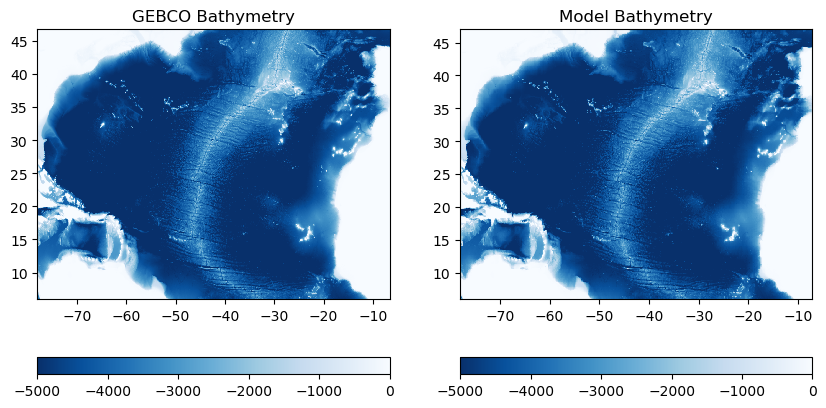

In [6]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

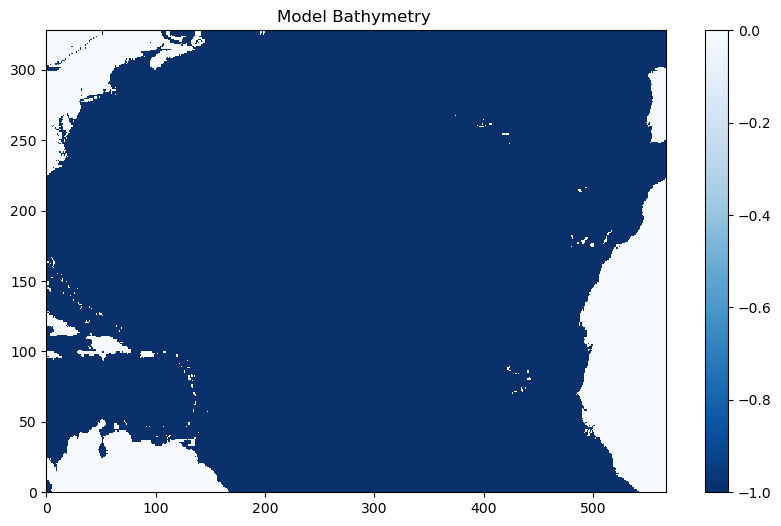

In [7]:
plt.figure(figsize=(10,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

### Fill unconnected / isolated regions

In [8]:
from eccoseas.downscale import bathymetry as edb

In [9]:
Model_bathy = edb.fill_unconnected_model_regions(Model_bathy, central_wet_row=200, central_wet_col=300)

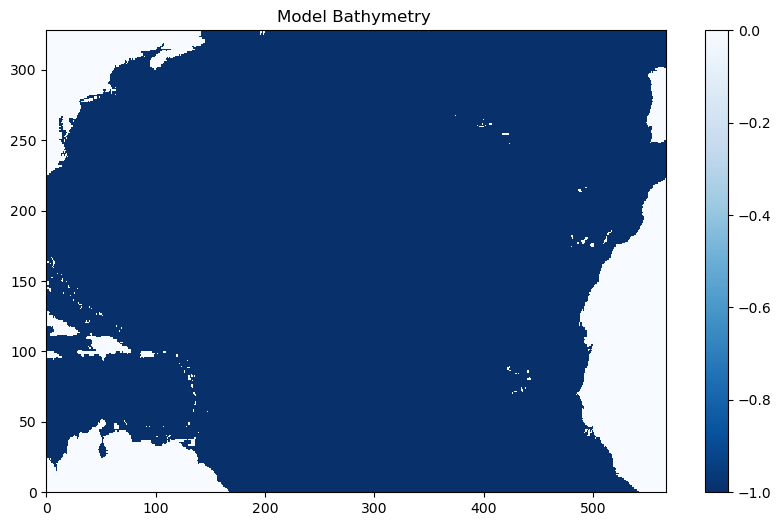

In [10]:
plt.figure(figsize=(10,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

In [11]:
Model_bathy_filled = np.copy(Model_bathy)
Model_bathy_filled[20:40, 40:60] = 0
Model_bathy_filled[252:270, 10:19] = 0

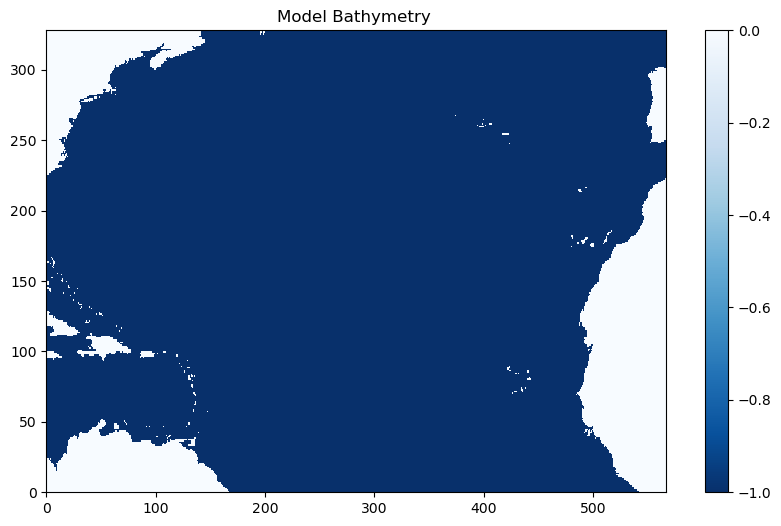

In [12]:
plt.figure(figsize=(10,6))

C = plt.pcolormesh(Model_bathy_filled, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

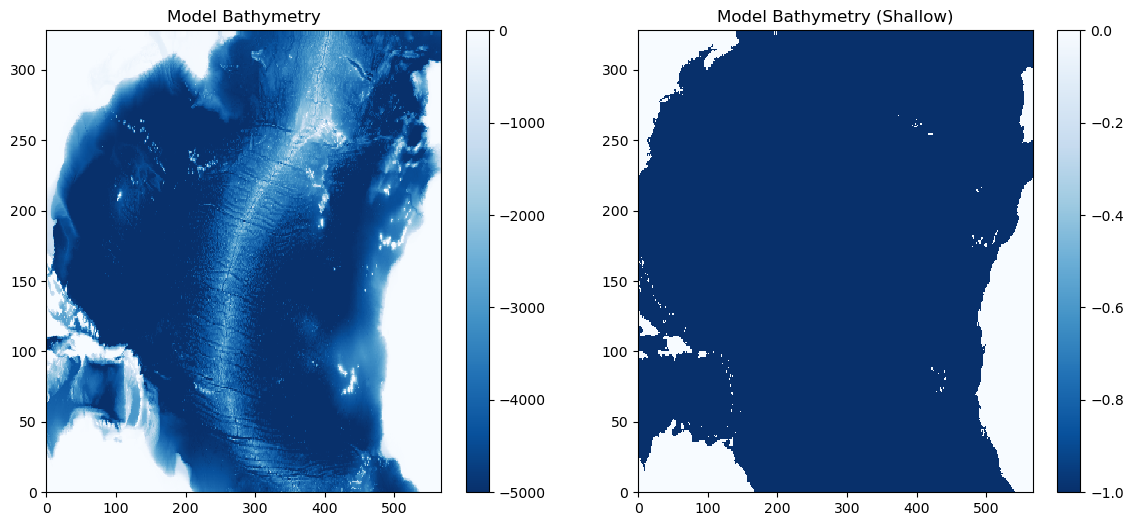

In [13]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
C = plt.pcolormesh(Model_bathy_filled, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(Model_bathy_filled, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry (Shallow)')

plt.show()

In [14]:
output_file = 'ATL_bathymetry.bin'
Model_bathy_filled.ravel('C').astype('>f4').tofile(output_file)

This will be implemented in the model by editing the line `PARM05` in the `data` file:
```
&PARM05
bathyFile = 'ATL_bathymetry.bin',
&
```